# Derivation of the Data-Generating Process

This notebook provides the full implementation for deriving the data-generating process described in the chapter **3.1 Experimental Design**. 

It consists of two main parts:

1. **Meta-feature selection** — identifying the single meta-feature with the highest explanatory power for predicting algorithm performance (mean and stdiance of accuracy).  
2. **Definition of functional forms** — determining the true function $f^{*(m)}(x)$ and the noise function $\sigma^{(m)}_\text{alea}(x)$ by fitting candidate functional forms to the empirical data.

The resulting functions serve as the basis for the synthetic data generation used throughout the experiments.

In [2]:
import sys
from functools import partial
from pathlib import Path
from typing import Callable

import numpy as np
from scipy.special import expit, softplus

project_root = Path.cwd().parent
sys.path.append(str(project_root))

from src.constants import ALGORITHM_PERFORMANCE_PATH
from src.utils.utils_candidate_functions import (
    build_fit_configs,
    define_base_function_single_feature,
    define_base_function_two_features,
    feature_combo_performance,
    generate_function_defs,
    plot_best_fit_grid_all,
)

### Meta-feature selection

In this section, each of the 72 meta-features from the UCR Time Series Archive is individually evaluated for its ability to predict an algorithm’s mean classification accuracy and its stdiability.  
For every feature, a Gaussian regression network is trained and evaluated using the NLL as performance criterion.  
The resulting NLL values are used to rank all features by their explanatory power, allowing identification of the most informative single feature — for example for the HC2 algorithm the "best" meta-feature would be $mean(||I_{c}||)$.

The following code iterates over all algorithm performance files, trains the single-feature models, and records the test NLL for each feature.



In [3]:
performance_path = ALGORITHM_PERFORMANCE_PATH
csv_files = performance_path.glob("*.csv")

df_single_feature_comparison = {}

for file_path in csv_files:
    algo_name = file_path.stem.replace("_ACC", "")
    print(f"Processing algorithm: {algo_name}")
    df_single_feature_comparison[algo_name] = feature_combo_performance(str(file_path), n_features=1)


Processing algorithm: ResNet
Processing algorithm: 1NN-DTW
Processing algorithm: EE
Processing algorithm: WEASEL-D
Processing algorithm: RSF
Processing algorithm: CNN
Processing algorithm: RIST
Processing algorithm: Catch22
Processing algorithm: TSF
Processing algorithm: RDST
Processing algorithm: TSFresh
Processing algorithm: ShapeDTW
Processing algorithm: DrCIF
Processing algorithm: CIF
Processing algorithm: Arsenal
Processing algorithm: BOSS
Processing algorithm: PF
Processing algorithm: ROCKET
Processing algorithm: WEASEL
Processing algorithm: FreshPRINCE
Processing algorithm: MrSQM
Processing algorithm: RSTSF
Processing algorithm: TS-CHIEF
Processing algorithm: Mini-R
Processing algorithm: Hydra-MR
Processing algorithm: Hydra
Processing algorithm: HC2
Processing algorithm: InceptionT
Processing algorithm: Signatures
Processing algorithm: STC
Processing algorithm: STSF
Processing algorithm: cBOSS
Processing algorithm: HC1
Processing algorithm: Multi-R
Processing algorithm: RISE
Pro

In [4]:
df_single_feature_comparison["HC2"]

,features,nll
0,"($mean(||I_{c}||)$,)",-1.029257
1,"($\sigma ($$CV$$)$,)",-1.009742
2,"($min(||I_{c}||)$,)",-1.004462
3,"($range ($$CV$$)$,)",-1.002221
4,"($||Y_{C}||$,)",-1.001182
...,...,...
67,"($\sigma ($$IQR$$)$,)",-0.820432
68,"($range ($$\gamma_{1}$$)$,)",-0.447293
69,"($\sigma ($$max(\Delta x)$$)$,)",-0.444684
70,"($\sigma ($$\sigma$$)$,)",0.305335


### Definition of functional forms for $f^*(x)$ and $\sigma^{(m)}_\text{alea}(x)$

After selecting the most informative meta-feature, this section derives the functional forms for the deterministic true function $f^{*(m)}(x)$ and the input-dependent noise function $\sigma^{(m)}_\text{alea}(x)$.  
Several candidate non-linear transformations $g(u) \in \{u^2, u^3, \exp(u), \sin(u), \cos(u)\}$ are fitted to the empirical mean and standard deviation of algorithm accuracies.  
For each candidate, parameters are optimized to minimize the Mean Absolute Error (MAE) between the predicted and observed values.  
The candidate achieving the lowest MAE defines the final function used in the data-generating process.

The code below builds the candidate functions, fits them to the data, and visualizes the resulting best-fit functions.


In [5]:
def _apply(func: Callable, 
           x: np.ndarray, 
           a: float, 
           b: float, 
           c: float, 
           d: float, 
           e: float, 
           activation: Callable):
     """Apply a base function with given parameters and activation."""
     return activation(a + b * (x + c) + d * func((x + e)))

#def f_linear(x, a, b, c, d, e, activation):     return _apply(lambda u: u,      x, a, b, c, d, e, activation)
def f_quadratic(x, a, b, c, d, e, activation):  return _apply(lambda u: u**2,   x, a, b, c, d, e, activation)
def f_cubic(x, a, b, c, d, e, activation):      return _apply(lambda u: u**3,   x, a, b, c, d, e, activation)
def f_exponential(x, a, b, c, d, e, activation):return _apply(np.exp,           x, a, b, c, d, e, activation)
def f_sinusoidal(x, a, b, c, d, e, activation): return _apply(np.sin,           x, a, b, c, d, e, activation)
def f_cosine(x, a, b, c, d, e, activation):     return _apply(np.cos,           x, a, b, c, d, e, activation)

def build_candidate_funcs_singlefeat(target):
    # softplus or std to keep outputs in [0, ∞)
    # expit (logistic sigmoid) or mean_accuracy to keep outputs in [0, 1]
    act = softplus if target == "std_accuracy" else expit
    return {
        "Quadratic":   partial(f_quadratic,   activation=act),
        "Cubic":       partial(f_cubic,       activation=act),
        "Exponential": partial(f_exponential, activation=act),
        "Sinusoidal":  partial(f_sinusoidal,  activation=act),
        "Cosine":      partial(f_cosine,      activation=act),
    }


In [6]:
performance_path = ALGORITHM_PERFORMANCE_PATH

CANDIDATE_FUNCS_MEAN = build_candidate_funcs_singlefeat("mean_accuracy")
CANDIDATE_FUNCS_STD = build_candidate_funcs_singlefeat("std_accuracy")

csv_files = sorted(performance_path.glob("*.csv"))

results_mean = {}
results_std = {}

for csv_file in csv_files:
    algo_name = csv_file.stem.replace("_ACC", "")

    df_feature_comparison = df_single_feature_comparison.get(algo_name)
    if df_feature_comparison is None:
        print(f"No feature comparison found for {algo_name}, skipping.")
        continue

    # --- MEAN ACCURACY ---
    df_func_results_mean, best_feat_mean, x_mean, y_mean = define_base_function_single_feature(
        df_feature_comparison=df_feature_comparison,
        target="mean_accuracy",
        test_algorithm_file=str(csv_file.name),
        candidate_funcs=CANDIDATE_FUNCS_MEAN,
    )
    results_mean[algo_name] = {
        "df_func_results": df_func_results_mean,
        "best_feat": best_feat_mean,
        "x": x_mean,
        "y": y_mean,
    }

    # --- std ACCURACY ---
    df_func_results_std, best_feat_std, x_std, y_std = define_base_function_single_feature(
        df_feature_comparison=df_feature_comparison,
        target="std_accuracy",
        test_algorithm_file=str(csv_file.name),
        candidate_funcs=CANDIDATE_FUNCS_STD,
    )
    results_std[algo_name] = {
        "df_func_results": df_func_results_std,
        "best_feat": best_feat_std,
        "x": x_std,
        "y": y_std,
    }

fit_configs_mean, fit_configs_std = build_fit_configs(
    results_mean, results_std, CANDIDATE_FUNCS_MEAN, CANDIDATE_FUNCS_STD
)

/Users/scheuringp/Coding/uq-algorithm-selection/src/utils/utils_candidate_functions.py:272: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(func, x, y, p0=[0, 0, 0, 0, 0], maxfev=10000)
/Users/scheuringp/Coding/uq-algorithm-selection/src/utils/utils_candidate_functions.py:272: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(func, x, y, p0=[0, 0, 0, 0, 0], maxfev=10000)
/Users/scheuringp/Coding/uq-algorithm-selection/src/utils/utils_candidate_functions.py:272: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(func, x, y, p0=[0, 0, 0, 0, 0], maxfev=10000)
/Users/scheuringp/Coding/uq-algorithm-selection/src/utils/utils_candidate_functions.py:272: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(func, x, y, p0=[0, 0, 0, 0, 0], maxfev=10000)
/Users/scheuringp/Coding/uq-algorithm-selection/src/utils/utils_candidate_functions.

In [7]:
results_mean["HC2"]["df_func_results"]

,non_linear_term,params,mae
0,Cosine,"[3.14459, -0.032208, 16.118847, 1.046249, 8.06...",0.085119
1,Sinusoidal,"[1.492823, -0.032208, -35.165638, -1.046248, 0...",0.085119
2,Cubic,"[1.526867, 1.635716, 3.803537, -0.039989, 1.20...",0.086273
3,Quadratic,"[1.622001, 0.113195, 2.896717, 0.015067, -1.62...",0.089232
4,Exponential,"[2.461253, -0.050892, 12.548648, 0.079868, -0....",0.090234


### Comparison all algorithms

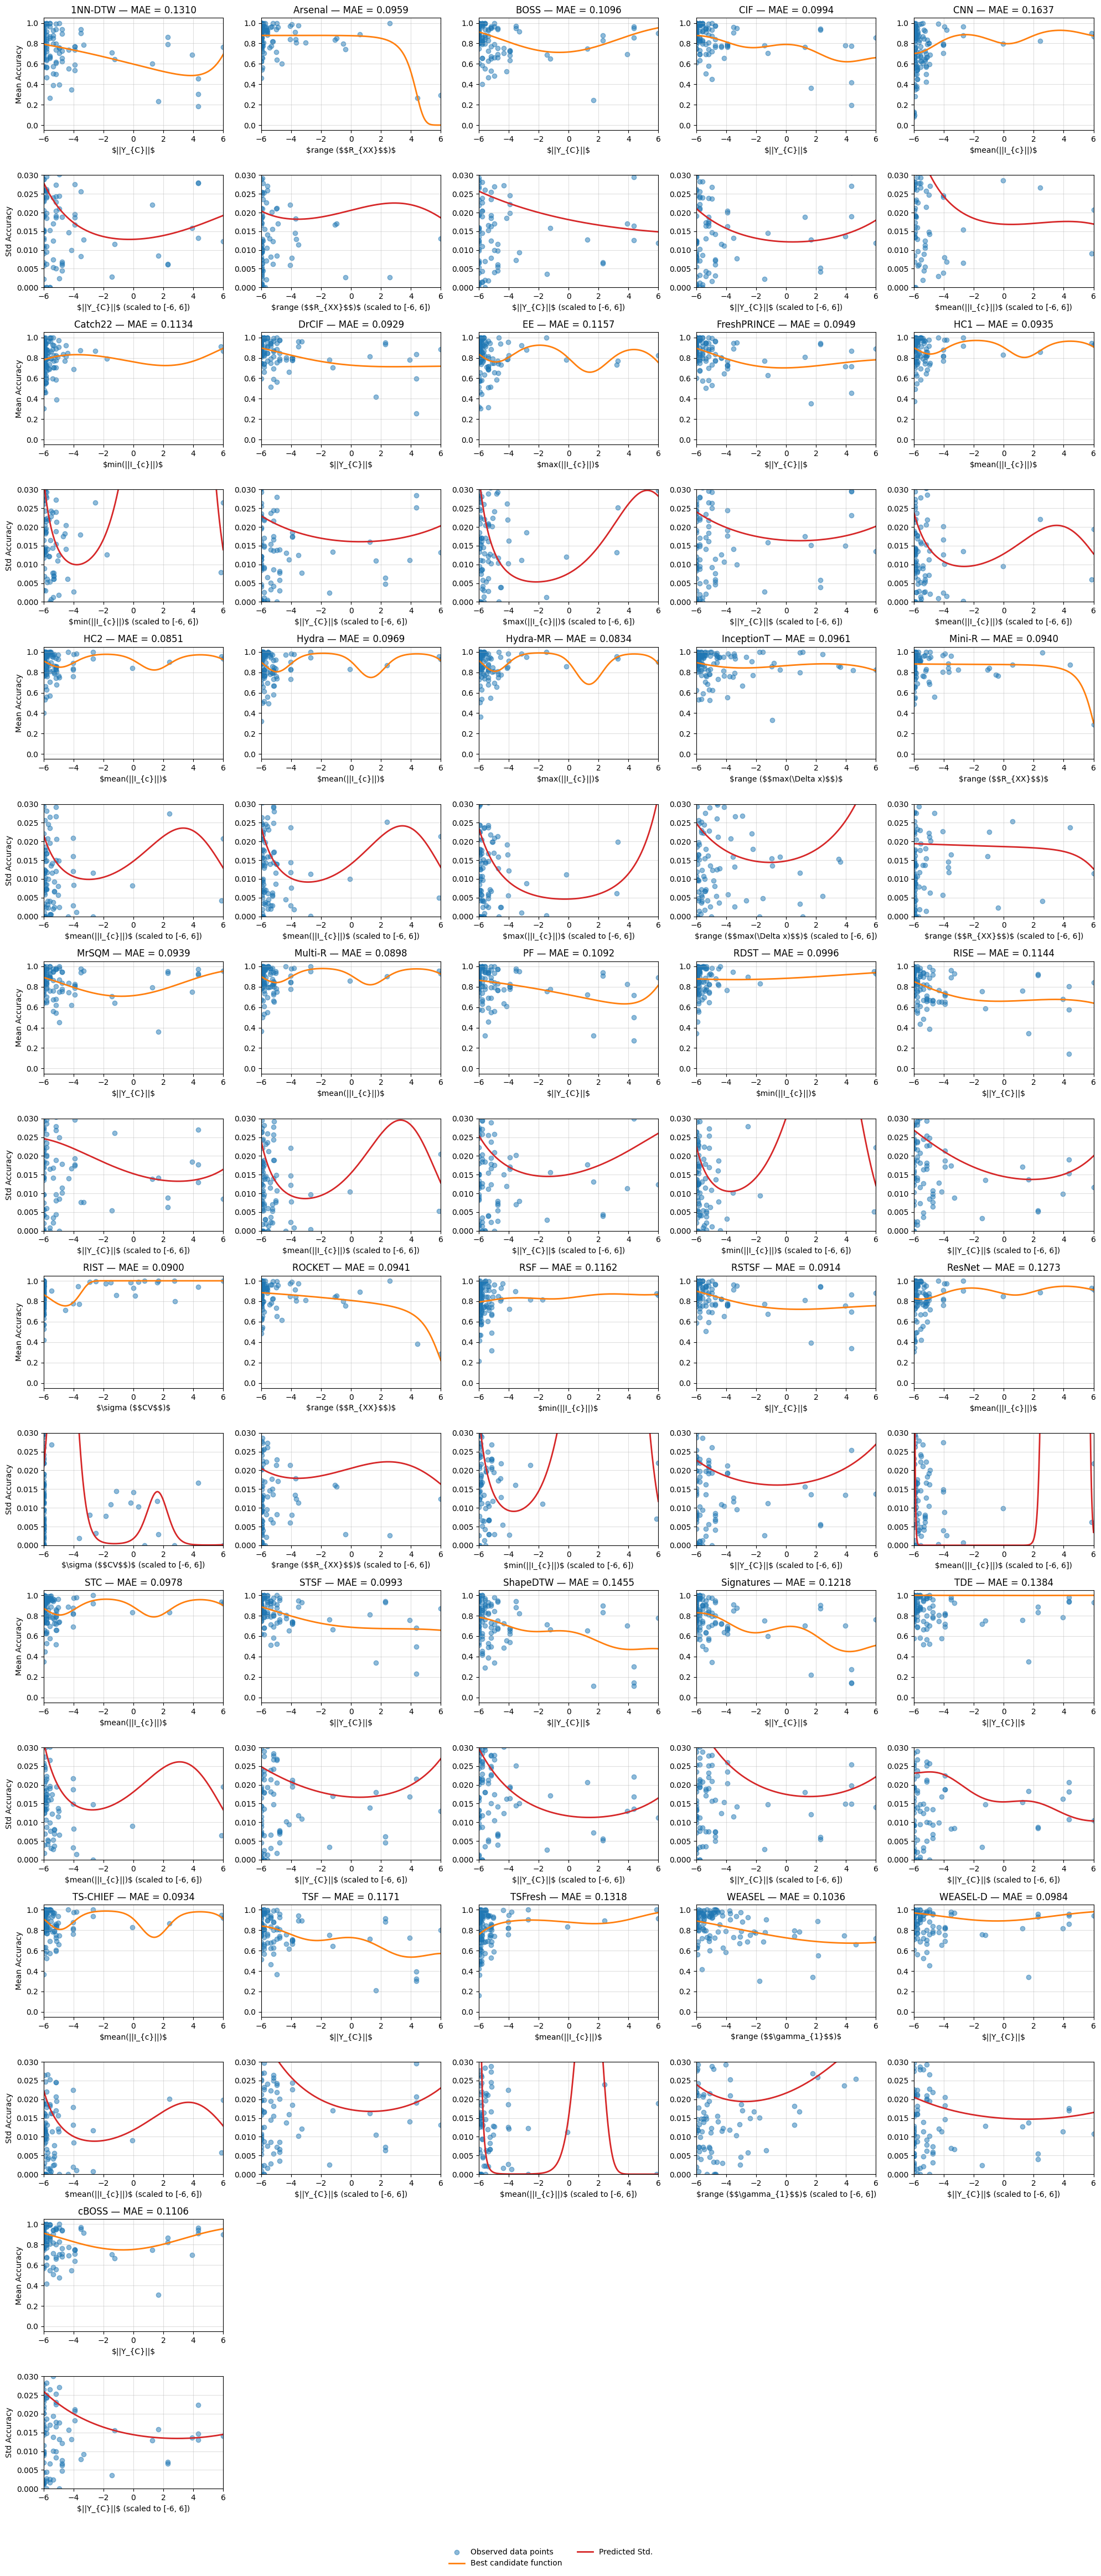

In [8]:
plot_best_fit_grid_all(
    fit_configs_mean=fit_configs_mean,
    fit_configs_std=fit_configs_std,
)

### Print functions of all algorithms

In [9]:
generate_function_defs(results_mean, results_std)

# 1NN-DTW
def f_exponential__1nn_dtw_1_feat(X: np.ndarray) -> np.ndarray:
    """Compute the true mean function f(x) for 1D input."""
    x1 = X[:, 0]
    return expit(
        -0.217447 - 0.157664 * (x1 - 3.847735) + 0.003027 * np.exp(x1 + 0.109256)
    )

def sigma_cubic__1nn_dtw_1_feat(X: np.ndarray) -> np.ndarray:
    """Compute the heteroscedastic noise σ(x) for 1D input."""
    x1 = X[:, 0]
    return softplus(
        -11.573856 + 0.089195 * (x1 + 79.579092) - 0.00115 * (x1 - 4.801252) ** 3
    )

# Arsenal
def f_exponential_arsenal_1_feat(X: np.ndarray) -> np.ndarray:
    """Compute the true mean function f(x) for 1D input."""
    x1 = X[:, 0]
    return expit(
        1.973566 + 0.00254 * (x1 + 4.521214) - 0.032041 * np.exp(x1 + 0.08652)
    )

def sigma_cubic_arsenal_1_feat(X: np.ndarray) -> np.ndarray:
    """Compute the heteroscedastic noise σ(x) for 1D input."""
    x1 = X[:, 0]
    return softplus(
        -54.086517 + 0.049867 * (x1 + 1006.965114) - 0.001591 * (x1 + 0.32

### Data-generating process (two features)

In this section, the same procedure as described for the one-dimensional case is extended to a two-dimensional input space as used in Experiment 4 of the thesis.  
Therefore, the true and noise functions are redefined as functions of two meta-features, $x_1$ and $x_2$.

The procedure follows the same structure as in the 1D setup:
1. Identify the pair of meta-features with the highest joint explanatory power for predicting algorithm accuracy.  
2. Fit candidate functional forms for the deterministic component $f^{*(m)}(x_1, x_2)$ and the noise component $\sigma_\text{alea}(x_1, x_2)$.

Differences to 1-dimensional process:
- For each candidate feature pair, both possible assignments of the linear and non-linear components are evaluated to determine which feature should act as the linear term in the final model.
- Due to the high computational cost of the search procedure, the analysis is restricted to the **HC2** algorithm.


In [2]:
df_two_feature_comparison_hc2 = feature_combo_performance("HC2_ACC.csv", n_features=2)

In [3]:
df_two_feature_comparison_hc2

,features,nll
0,"($\sigma ($$CV$$)$, $||Y_{C}||$)",-1.185871
1,"($IQR ($$max(\Delta x)$$)$, $||Y_{C}||$)",-1.153040
2,"($\sigma ($$CV$$)$, $mean(||I_{c}||)$)",-1.151903
3,"($\sigma ($$CV$$)$, $range ($$R_{XX}$$)$)",-1.151117
4,"($range ($$CV$$)$, $min(||I_{c}||)$)",-1.139941
...,...,...
2551,"($IQR ($max$)$, $\sigma ($$IQR$$)$)",48.170532
2552,"($\sigma ($$\sigma$$)$, $IQR ($max$)$)",48.953846
2553,"($IQR ($$IQR$$)$, $||Y_{C}||$)",52.751915
2554,"($IQR ($$\sigma$$)$, $||Y_{C}||$)",105.634636


In [4]:
def _apply(func: Callable, 
           x1: np.ndarray,
           x2: np.ndarray,
           a: float, 
           b: float, 
           c: float, 
           d: float, 
           e: float, 
           activation: Callable):
     """Apply a base function with given parameters and activation."""
     return activation(a + b * (x1 + c) + d * func((x2 + e)))

def f_quadratic_twofeat(x1, x2, a, b, c, d, e, activation):  return _apply(lambda u: u**2,   x1, x2, a, b, c, d, e, activation)
def f_cubic_twofeat(x1, x2, a, b, c, d, e, activation):      return _apply(lambda u: u**3,   x1, x2, a, b, c, d, e, activation)
def f_exponential_twofeat(x1, x2, a, b, c, d, e, activation):return _apply(np.exp,           x1, x2, a, b, c, d, e, activation)
def f_sinusoidal_twofeat(x1, x2, a, b, c, d, e, activation): return _apply(np.sin,           x1, x2, a, b, c, d, e, activation)
def f_cosine_twofeat(x1, x2, a, b, c, d, e, activation):     return _apply(np.cos,           x1, x2, a, b, c, d, e, activation)

def build_candidate_funcs_twofeat(target):
    # softplus or var to keep outputs in [0, ∞)
    # expit (logistic sigmoid) or mean_accuracy to keep outputs in [0, 1]
    act = softplus if target == "var_accuracy" else expit
    return {
        "Quadratic":   partial(f_quadratic_twofeat,   activation=act),
        "Cubic":       partial(f_cubic_twofeat,       activation=act),
        "Exponential": partial(f_exponential_twofeat, activation=act),
        "Sinusoidal":  partial(f_sinusoidal_twofeat,  activation=act),
        "Cosine":      partial(f_cosine_twofeat,      activation=act),
    }


In [5]:
### MEAN ACCURACY ###
CANDIDATE_FUNCS_MEAN = build_candidate_funcs_twofeat("mean_accuracy")

df_twofeat_func_results_hc2_mean, best_twofeat_hc2_mean, x1_hc2_mean, x2_hc2_mean, y_hc2_twofeat_mean = define_base_function_two_features(
    df_feature_comparison=df_two_feature_comparison_hc2,
    target="mean_accuracy",
    test_algorithm_file="HC2_ACC.csv",
    candidate_funcs=CANDIDATE_FUNCS_MEAN,
)

### STD ACCURACY ###
CANDIDATE_FUNCS_STD = build_candidate_funcs_twofeat("std_accuracy")

df_twofeat_func_results_hc2_std, best_twofeat_hc2_std, x1_hc2_std, x2_hc2_std, y_hc2_twofeat_std = define_base_function_two_features(
    df_feature_comparison=df_two_feature_comparison_hc2,
    target="std_accuracy",
    test_algorithm_file="HC2_ACC.csv",
    candidate_funcs=CANDIDATE_FUNCS_STD,
)

In [6]:
df_twofeat_func_results_hc2_mean

,non_linear_term,linear_term,params,mae
0,Quadratic,x1,"[4.956188, 0.160603, -17.817124, 0.038322, 0.5...",0.079705
1,Sinusoidal,x1,"[-8.782244, 0.161096, 74.995726, -0.783498, -0...",0.081647
2,Cosine,x1,"[27.312885, 0.161096, -149.06532, 0.783339, 1....",0.081650
3,Cubic,x1,"[2.64553, 0.189113, -0.160399, -0.00115, -2.40...",0.082802
4,Exponential,x2,"[1.946926, -0.040043, 4.511864, 0.031465, 5.94...",0.084985
5,Cubic,x2,"[65.126, -0.045651, -27.775228, 0.0, -968.272515]",0.085317
6,Quadratic,x2,"[50.547891, -0.045651, -11.275584, -0.000201, ...",0.085318
7,Exponential,x1,"[1.34152, 0.189503, 9.34718, 0.002529, -0.437792]",0.085627
8,Cosine,x2,"[4.553312, -0.050792, 43.5785, -0.58172, -0.68...",0.087888
9,Sinusoidal,x2,"[2.00725, -0.050793, -6.547607, -0.581707, 0.8...",0.087889


In [7]:
df_twofeat_func_results_hc2_std

,non_linear_term,linear_term,params,mae
0,Quadratic,x1,"[-4.999376, -0.106637, 1.131506, 0.002686, -9....",0.012660
1,Cubic,x1,"[-9.645975, -0.10647, -39.831553, -2e-05, -29....",0.012670
2,Sinusoidal,x1,"[-5.653407, -0.101868, -8.687136, 0.325071, 0....",0.012678
3,Cosine,x1,"[-18.806469, -0.101869, -137.804648, -0.325073...",0.012678
4,Quadratic,x2,"[-34.603611, -0.061159, -12.256704, 9.6e-05, -...",0.012692
5,Cubic,x2,"[-10.552519, -0.056989, -101.861268, -0.002445...",0.012696
6,Exponential,x1,"[-3.815606, -0.098061, 6.963018, -0.155877, -4...",0.012837
7,Exponential,x2,"[-5.895425, -0.068978, -23.506256, -0.746356, ...",0.012846
8,Sinusoidal,x2,"[-1.363823, -0.048788, 65.115784, 0.479537, 0....",0.012857
9,Cosine,x2,"[-1.49243, -0.048788, 62.478979, -0.479537, -4...",0.012857
